In [2]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

# Remember, the windows are the INVERSE of the absorption features
# Next - build ability to choose seed (both in make_specs and empca)

Populating the interactive namespace from numpy and matplotlib


test_empca.py:35: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if proportion == 'real':

       iter        R2             rchi2
EMPCA  1/25       0.00552716      0.00006259
EMPCA  2/25       0.02956191      0.00006108
EMPCA  3/25       0.05580596      0.00005943
EMPCA  4/25       0.06004429      0.00005916
EMPCA  5/25       0.06185444      0.00005905
R2: 0.062833937092
       iter        R2             rchi2
EMPCA  1/25       0.00432990      1.07171981
EMPCA  2/25       0.02566023      1.03211197
EMPCA  3/25       0.04835901      0.99692936
EMPCA  4/25       0.04887323      0.99637538
R2: 0.0490393892689
[ 0.          0.03095843  0.03217193  0.03377819  0.03467294  0.03627232] [ 0.          0.0319004   0.03390768  0.03647363  0.03882986  0.04105874]
var, Vnoise  6.24366568854e-05 6.00855053176e-05
       iter        R2             rchi2
EMPCA  1/25       0.28121409      0.00001146
EMPCA  2/25       0.59

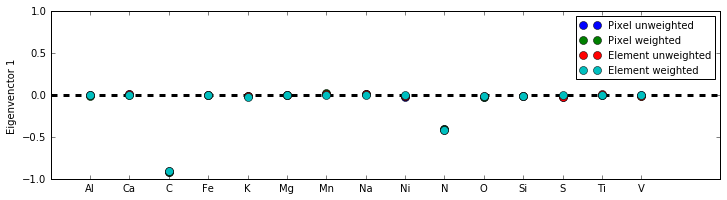

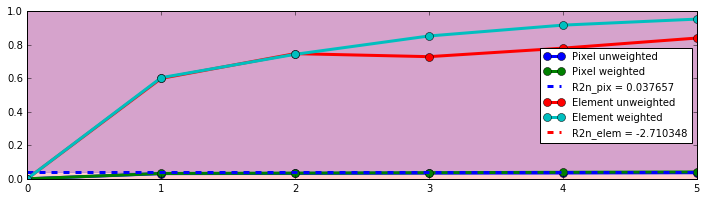

In [26]:
run test_empca -i 1

In [27]:
m1.R2(5)

0.21104397838846922

In [20]:
 m1,m2,w1,w2 = pix_empca(None,falsespecs.T,noise,'test.pkl',nvecs=5,deltR2=2e-3,gen=True,usemad=False,randseed=1)

In [21]:
m1

In [23]:
m2.R2(0)

0.0

In [2]:
run run_empca -vugp -m red_clump/pickles/models/model_FE_H_u-0.1_d-0.105.pkl -d 2e-3 -n 14

/usr/lib/python2.7/site-packages/setuptools-18.7.1-py2.7.egg/pkg_resources/__init__.py:1266: UserWarning: /home/price-jones/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
/home/price-jones/Code/apogee/apogee/spec/window.py:88: RuntimeWarning: invalid value encountered in greater
  mask= ((win > 0.)*(True-numpy.isnan(win))).astype('int')


KeyboardInterrupt: 

In [3]:
run run_residuals -vx -i FE_H -u -0.1 -d -0.105 -s red_clump -c None -l 50,200

/usr/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


Initialization runtime 1.81 s
Number of stars 194

Nonzero Minimum SNR before mask 0.0012
Maximum SNR before correction 219.82
SNR cut runtime 0.04 s
Minimum SNR after mask 50.0025
Maximum SNR after correction 200.00

SNR correction runtime 0.01 s

Bitmask application runtime 0.06 s

Pixel residuals runtime 130.73 s
Maximum residual 0.189782471534 

Finding random sigma runtime 1.17 s



In [28]:
run run_empca -vg -m red_clump/pickles/models/model_FE_H_u-0.1_d-0.105.pkl -d 2e-3 -n 14

PIXEL SPACE
number of unusable pixels,  0
       iter        R2             rchi2
EMPCA  1/25       0.03713880      0.00013244
EMPCA  2/25       0.27950629      0.00009910
EMPCA  3/25       0.32145888      0.00009333
EMPCA  4/25       0.34170710      0.00009055
EMPCA  5/25       0.35319621      0.00008897
EMPCA  6/25       0.35969368      0.00008807
EMPCA  7/25       0.36370798      0.00008752
EMPCA  8/25       0.36709425      0.00008705
EMPCA  9/25       0.36949519      0.00008672
EMPCA 10/25       0.37093836      0.00008653
R2: 0.375601695571
nans  (array([], dtype=int64), array([], dtype=int64))
       iter        R2             rchi2
EMPCA  1/25       0.03521055      2.66621347
EMPCA  2/25       0.24338655      2.01565723
EMPCA  3/25       0.28467174      1.88970950
EMPCA  4/25       0.30844198      1.81745237
EMPCA  5/25       0.32227247      1.77528165
EMPCA  6/25       0.32802271      1.75618094
EMPCA  7/25       0.32979765      1.74933734
R2: 0.339633306937
Pixel runtime (unwei

In [6]:
import access_spectrum as acs
model = acs.pklread('red_clump/pickles/models/model_FE_H_u-0.1_d-0.105.pkl')
elems = ['Al','Ca','C','Fe','K','Mg','Mn','Na','Ni','N','O','Si','S','Ti','V']
aspcappix = 7214

In [7]:
def randomize_residual(residual,uncertainty):
    return uncertainty.T*np.random.randn(residual.shape[0],residual.shape[1])+residual

def weight(residual,numstars,model):
    weighted = np.ma.masked_array(np.zeros((len(elems),numstars)))
    i=0
    for elem in elems:
        weighted[i] = model.weighting_stars(residual,elem)
        i+=1
    return weighted

In [8]:
iters=1000
randoms = np.ma.masked_array(np.zeros((iters,len(elems),model.numstars)))
rands = np.ma.masked_array(np.zeros((iters,aspcappix,model.numstars)))
for i in range(iters):
    rand_resid = randomize_residual(model.residual,model.errs)
    rands[i] = rand_resid
    randoms[i] = weight(rand_resid,model.numstars,model)

In [14]:
randoms.shape

(1000, 15, 194)

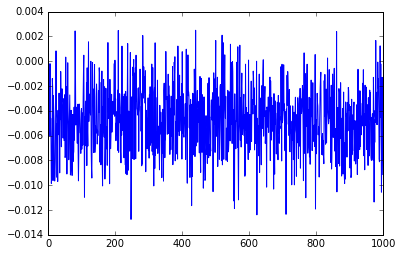

In [9]:
plt.plot(randoms[:,14,0])

In [10]:
stds_pix = np.ma.masked_array(np.zeros((aspcappix,model.numstars)))
for i in range(aspcappix):
    pix_rands = rands[:,i]
    stds_pix[i] = np.ma.std(pix_rands,axis=0)
stds_pix.mask = model.errs.T.mask
diff_pix = model.errs.T - stds_pix

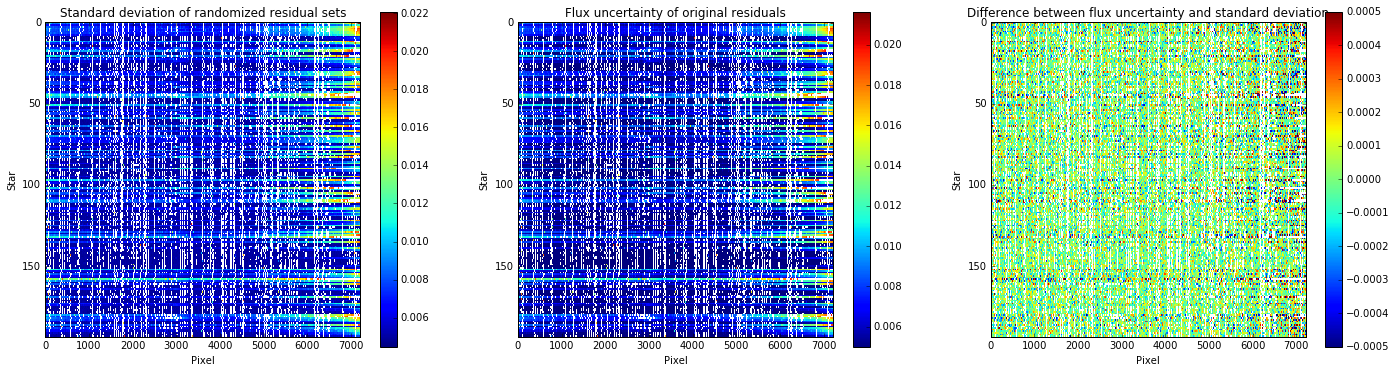

In [11]:
plt.figure(figsize=(24,6))
plt.subplot2grid((1,3),(0,0))
plt.imshow(stds_pix.T,aspect = float(stds_pix.shape[0])/stds_pix.shape[1],interpolation='nearest')
plt.xlabel('Pixel')
plt.ylabel('Star')
plt.title('Standard deviation of randomized residual sets')
plt.colorbar()
plt.subplot2grid((1,3),(0,1))
plt.imshow(model.errs,aspect = float(stds_pix.shape[0])/stds_pix.shape[1],interpolation='nearest')
plt.xlabel('Pixel')
plt.ylabel('Star')
plt.title('Flux uncertainty of original residuals')
plt.colorbar()
plt.subplot2grid((1,3),(0,2))
plt.imshow(diff_pix.T,aspect = float(stds_pix.shape[0])/stds_pix.shape[1],interpolation='nearest',vmin=-5e-4,vmax=5e-4)
plt.xlabel('Pixel')
plt.ylabel('Star')
plt.title('Difference between flux uncertainty and standard deviation')
plt.colorbar()


In [19]:
stds_elem = np.zeros((len(elems),model.numstars))
for i in range(len(elems)):
    elem_rands = randoms[:,i]
    stds_elem[i] = np.ma.std(elem_rands,axis=0)
diff_elem = errs - stds_elem

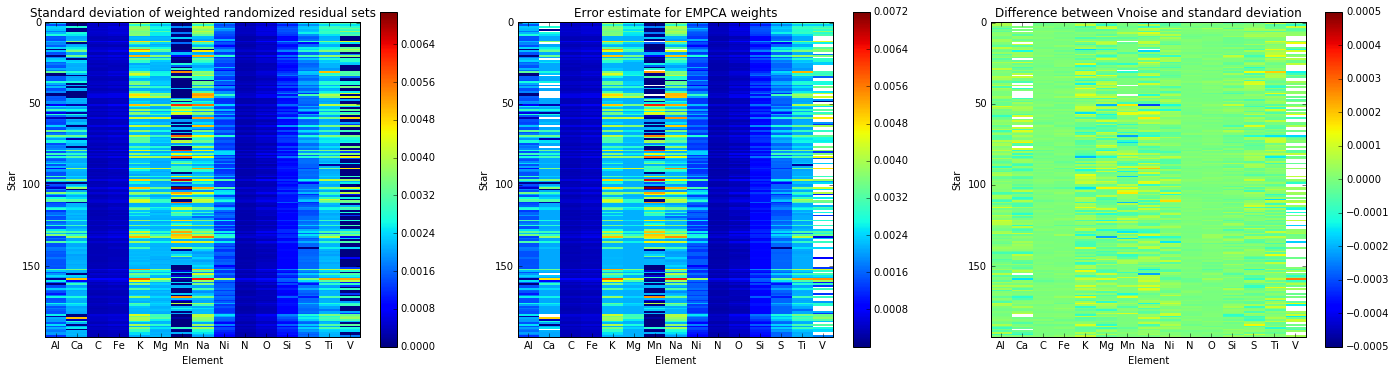

In [30]:
plt.figure(figsize=(24,6))
plt.subplot2grid((1,3),(0,0))
plt.imshow(stds_elem,aspect = float(stds_elem.shape[1])/stds_elem.shape[0],interpolation='nearest')
plt.xticks(range(len(elems)),elems)
plt.xlabel('Element')
plt.ylabel('Star')
plt.title('Standard deviation of weighted randomized residual sets')
plt.colorbar()
plt.subplot2grid((1,3),(0,1))
plt.imshow(errs.T,aspect = float(stds_elem.shape[1])/stds_elem.shape[0],interpolation='nearest')
plt.xticks(range(len(elems)),elems)
plt.xlabel('Element')
plt.ylabel('Star')
plt.title('Error estimate for EMPCA weights')
plt.colorbar()
plt.subplot2grid((1,3),(0,2))
plt.imshow(diff_elem.T,aspect = float(stds_elem.shape[1])/stds_elem.shape[0],interpolation='nearest',vmin=-5e-4,vmax=5e-4)
plt.xticks(range(len(elems)),elems)
plt.xlabel('Element')
plt.ylabel('Star')
plt.title('Difference between Vnoise and standard deviation')
plt.colorbar()

In [159]:
argument=model.data['TEFF']>4500

In [160]:
argument

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [170]:
model.getData()

In [173]:
import apogee.tools.read as apread
test = apread.rcsample()

In [190]:
test.dtype

dtype([('APSTAR_ID', 'S45'), ('ASPCAP_ID', 'S44'), ('APOGEE_ID', 'S18'), ('TELESCOPE', 'S8'), ('LOCATION_ID', '>i2'), ('FIELD', 'S16'), ('J', '>f4'), ('J_ERR', '>f4'), ('H', '>f4'), ('H_ERR', '>f4'), ('K', '>f4'), ('K_ERR', '>f4'), ('RA', '>f8'), ('DEC', '>f8'), ('GLON', '>f8'), ('GLAT', '>f8'), ('APOGEE_TARGET1', '>i4'), ('APOGEE_TARGET2', '>i4'), ('TARGFLAGS', 'S116'), ('NVISITS', '>i4'), ('COMMISS', '>i2'), ('SNR', '>f4'), ('STARFLAG', '>i4'), ('STARFLAGS', 'S129'), ('ANDFLAG', '>i4'), ('ANDFLAGS', 'S59'), ('VHELIO_AVG', '>f4'), ('VSCATTER', '>f4'), ('VERR', '>f4'), ('VERR_MED', '>f4'), ('STABLERV_CHI2', '>f4', (2,)), ('STABLERV_RCHI2', '>f4', (2,)), ('STABLERV_CHI2_PROB', '>f4', (2,)), ('EXTRATARG', '>i2'), ('PARAM', '>f4', (7,)), ('FPARAM', '>f4', (7,)), ('PARAM_COV', '>f4', (7, 7)), ('FPARAM_COV', '>f4', (7, 7)), ('ELEM', '>f4', (15,)), ('FELEM', '>f4', (15,)), ('ELEM_ERR', '>f4', (15,)), ('FELEM_ERR', '>f4', (15,)), ('TEFF', '>f4'), ('LOGG', '>f4'), ('PARAM_M_H', '>f4'), ('PARAM

In [216]:
class dogInfo(object):
    def __init__(self,name,age,arr):
        self.name = name
        self.age = age
        self.arr = arr

In [217]:
names = ['Larry','Curly','Moe']
ages = [10,4,7]
arrs = [np.arange(1,5),np.arange(1,5)+1,np.arange(1,5)+2]

In [218]:
dogs = []
for i in range(len(names)):
    dogs.append(dogInfo(names[i],ages[i],arrs[i]))

In [199]:
dogs

In [205]:
[dogs[i].name for i in range(len(dogs))]

['Larry', 'Curly', 'Moe']

In [206]:
moe = dogs[-1]

In [215]:
(test['TEFF'] > 4500) & (test['TEFF'] < 4600)

array([False, False, False, ..., False, False, False], dtype=bool)

In [220]:
np.array([dogs[i].arr for i in range(len(dogs))])

array([[1, 2, 3, 4],
       [2, 3, 4, 5],
       [3, 4, 5, 6]])